In [1]:
import networkx as nx
import dgl
import torch
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
import torch as th
import numpy as np
import scipy.sparse as spp

# Create the same graph from a list of integer pairs.
elist = [(0, 1),(1, 2),(2, 3),(2,6), (3, 4),(4, 5),(6, 7),(7, 8),(8, 6),(8, 9)]
graph_skelton = dgl.DGLGraph(elist)

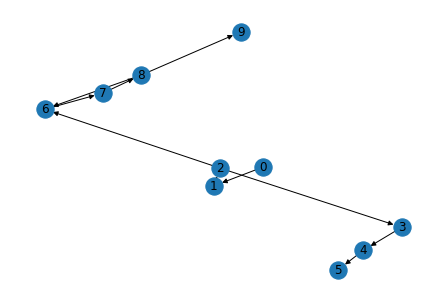

In [3]:
# Visualize the graph.
#graph_skelton.add_edges([9, 0])
nx.draw(graph_skelton.to_networkx(), with_labels=True)
plt.show()

In [4]:
x = th.tensor([10.0,20.0,40.0,20.0,50.0,80.0,70.0,10.0,40.0,20.0])
graph_skelton.edata['edge_weights'] = x

In [5]:
y = th.tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
graph_skelton.ndata['pv'] = y

In [6]:
account_balance = th.tensor([20.0,100.0,90.0,40.0,10.0,50.0,30.0,70.0,10.0,30.0])
graph_skelton.ndata['balance'] = account_balance

In [7]:
#graph_skelton.edata['edge_weights'][graph_skelton.edge_id(8, 6)]

In [8]:
#graph_skelton.edata['edge_weights'][graph_skelton.edge_id(1,2)]

### reverse the graph 

In [9]:
rg =graph_skelton.reverse(share_ndata=True, share_edata=True)

In [10]:
#rg.edata['edge_weights'][rg.edge_id(1, 0)] = 555

In [11]:
#graph_skelton= rg.reverse(share_ndata=True, share_edata=True)

In [12]:
#graph_skelton.edata['edge_weights']

In [13]:
# def pagerank_message_func2(graph):
    
#     list = graph.successors(graph.nodes())
#     sum=0
    
#     for node in graph.nodes():
#         sum=0
        
        
#     for succ in list:
#         sum= sum+ graph.edata['edge_weights'][graph.edge_ids(graph.nodes(), succ)]

#     #out_edge_weights=sum(graph.edata['edge_weights'][graph.edge_ids(graph.nodes(), graph.successors(graph.nodes())) ])
        
#     return {'edge_weights' : graph.edata['edge_weights'] }

### message passing functions

In [14]:
def pagerank_message_func(edges):
    return {'edge_weights' : edges.data['edge_weights'] + edges.src['pv']}

In [15]:
DAMP = 0.8  # damping factor
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['edge_weights'], dim=1)
    pv = DAMP * msgs
    return {'pv' : pv}

In [16]:
# register the above message and reduce function to the reversed graph
rg.register_message_func(pagerank_message_func)
rg.register_reduce_func(pagerank_reduce_func)

In [17]:
# Iterate k times of message passing
K=10
for k in range(K):
    rg.send(rg.edges())
    rg.recv(rg.nodes())
    print(rg.ndata['pv'])

tensor([ 8., 16., 48., 40., 64.,  0., 56.,  8., 48.,  0.])
tensor([ 20.8000,  54.4000, 124.8000,  91.2000,  64.0000,   0.0000,  62.4000,
         46.4000,  92.8000,   0.0000])
tensor([ 51.5200, 115.8400, 170.8800,  91.2000,  64.0000,   0.0000,  93.1200,
         82.2400,  97.9200,   0.0000])
tensor([100.6720, 152.7040, 195.4560,  91.2000,  64.0000,   0.0000, 121.7920,
         86.3360, 122.4960,   0.0000])
tensor([130.1632, 172.3648, 218.3936,  91.2000,  64.0000,   0.0000, 125.0688,
        105.9968, 145.4336,   0.0000])
tensor([145.8918, 190.7149, 221.0150,  91.2000,  64.0000,   0.0000, 140.7974,
        124.3469, 148.0550,   0.0000])
tensor([160.5719, 192.8120, 233.5979,  91.2000,  64.0000,   0.0000, 155.4775,
        126.4440, 160.6380,   0.0000])
tensor([162.2496, 202.8784, 245.3420,  91.2000,  64.0000,   0.0000, 157.1552,
        136.5104, 172.3820,   0.0000])
tensor([170.3027, 212.2736, 246.6842,  91.2000,  64.0000,   0.0000, 165.2083,
        145.9056, 173.7242,   0.0000])
tenso

..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [18]:
graph_skelton= rg.reverse(share_ndata=True, share_edata=True)

In [19]:
graph_skelton.ndata['pv']

tensor([177.8189, 213.3474, 253.1267,  91.2000,  64.0000,   0.0000, 172.7245,
        146.9794, 180.1666,   0.0000])

### traversing through the graph to find the optimum path

In [20]:
#graph_skelton.nodes( max(graph_skelton.ndata['pv']) )

In [21]:
src, dst, eid = graph_skelton.out_edges(2,'all')

In [22]:
# final transaction history between security accounts

source_nodes=[]
destination_nodes=[]
Amount_list=[]

In [23]:
# check the other available nodes from current node

def next_possible_nodes(graph, current_node):
    src, dst, eid = graph.out_edges(current_node,'all')
    if len(dst) !=0:
        dst.sort()
        possible_nodes= dst.tolist()
    else:
        possible_nodes=[]
    
    return possible_nodes


In [24]:
next_possible_nodes(graph_skelton,2)

[3, 6]

In [25]:
#transaction between two accounts

def transaction(graph, src, dst, amount):
    source_nodes.append(src)
    destination_nodes.append(dst)
    Amount_list.append(amount)
    
    graph.nodes[src].data['balance'] = graph.nodes[src].data['balance'] - amount
    graph.nodes[dst].data['balance'] = graph.nodes[dst].data['balance'] + amount
    graph.remove_edges([graph.edge_id(src,dst)])
    

In [26]:
# node_path=[]

# def choose_next_node(graph, current_node):
#     src, dst, eid = graph.out_edges(current_node,'all')
#     max_val=0
#     for dst_node in dst:
#         print(graph.nodes[dst_node].data['pv'])
#         if graph.nodes[dst_node].data['pv'] > max_val:
#             max_val = graph.nodes[dst_node].data['pv']
#             max_node = dst_node

#     node_path.append(max_node)

# choose_next_node(graph_skelton,2)

In [27]:
## change the praph_skelton from get_pv() method
def get_pv(e):
    return graph_skelton.nodes[e].data['pv']


In [1]:
## a graph walk using a recursive function

def graph_walk(graph, current_node):
    
    n_p_nodes = next_possible_nodes(graph, current_node)
    
    if n_p_nodes:
        n_p_nodes.sort(reverse=True, key= get_pv)
        
        for next_node in n_p_nodes:
                   
            amount = graph.edata['edge_weights'][graph.edge_id(current_node, next_node)]
            if graph.nodes[current_node].data['balance'] >= amount:
                print('from node ' , current_node , ' to ' , next_node , ' | amount = ', amount)
                transaction(graph, current_node, next_node, amount)
                graph_walk(graph,next_node)
            
            elif graph.nodes[current_node].data['balance'] >0:
                print('from node ' , current_node , ' to ' , next_node , ' | amount = ', graph.nodes[current_node].data['balance'][0])
                transaction(graph, current_node, next_node, graph.nodes[current_node].data['balance'][0])
                graph_walk(graph,next_node)
    
graph_walk(graph_skelton, 0)

NameError: name 'graph_skelton' is not defined

In [29]:
#graph_skelton.edata['edge_weights'][graph_skelton.edge_id(6, 7)]

In [35]:
# transaction from
source_nodes

[0, 1, 2, 6, 7, 8, 2, 3, 4]

In [36]:
# transation to
destination_nodes

[1, 2, 6, 7, 8, 6, 3, 4, 5]

In [37]:
# transaction amount
Amount_list

[tensor(10.),
 tensor(20.),
 tensor(20.),
 tensor([50.]),
 tensor(10.),
 tensor([20.]),
 tensor(40.),
 tensor(50.),
 tensor([60.])]

In [38]:
#th.tensor([20.0,100.0,90.0,40.0,10.0,50.0,30.0,70.0,10.0,30.0])
graph_skelton.nodes[8].data['balance']

tensor([0.])

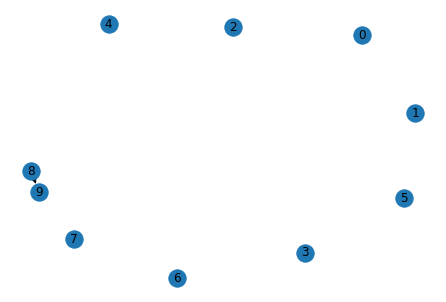

In [34]:
nx.draw(graph_skelton.to_networkx(), with_labels=True)
plt.show()